In [ ]:
import pandas as pd
import numpy as np

import requests 
import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

<h1 align=center><font size = 6>Capstone Project - Clustering of London's Crime Areas </font></h1>

This notebook will be used for the IBM Applied Data Science Specialisation Capstone Project

<h2 align=Left><font size = 5>Introduction </font></h1>

The purpose of this project is to segment the different neighbourhoods of London by the different types of crime which occur. This would be of use to:
1) Residents of London - So they can protect themselves of such crimes.

2) Tourists - As above and for an awareness of what crimes to expect in different areas.

3) Businesses - As above and so they can take out appropriate insurance.

4) Insurance companies - Can set insurance premiums taking into consideration the prevalance of crime in a certain neighbourhood.

If required for the course London will also be segmented by Venues (from the Fouraquare API) to see if there is a link to crime 🤨-> 👨+🍔=🦹‍♂️ ->🤷‍♂️

<h2 align=Left><font size = 5>The Data </font></h2>

The Crime data will be obtained using the UK Police's API/Crime Data, filtering the data from crimes in 2019 (to exlcude imapcts of Covid-19) by the Metropolitan Police Service which is London's police force (excluding the City of London/"The Square Mile"). 

Documentation on the API can be found on:https://data.police.uk/docs/ and https://police-api-client-python.readthedocs.io/en/latest/ and Crime Data from https://data.police.uk/data/

Crimes for which location data exists are presented by neighbourhood and latitude and longitude of the crime location. The latitide and longitude data of the neighbourhood of the crime will be used to cluster London's neighbourhood.

<h3 align=Left><font size = 4>The Crime Data </font></h3>

In [97]:
#crime=popo_api.get_crimes_area(n[0].boundary, date='2019-01')
eg_crimedata=pd.read_csv('2019-01-metropolitan-street.csv') #Crime Data from https://data.police.uk/data/
eg_crimedata.head(5)

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
0,a8977a2a4e14252420371eb993d52e4d0b8288a7c833e6...,2019-01,Metropolitan Police Service,Metropolitan Police Service,-0.709911,50.784615,On or near Rochester Way,E01031384,Arun 018E,Violence and sexual offences,Status update unavailable,NaN
1,NaN,2019-01,Metropolitan Police Service,Metropolitan Police Service,0.140192,51.582311,On or near Hatch Grove,E01000027,Barking and Dagenham 001A,Anti-social behaviour,NaN,NaN
2,934e173f2bc2e1dd3a257b37939d8f97575d3eeb89ff0c...,2019-01,Metropolitan Police Service,Metropolitan Police Service,0.140192,51.582311,On or near Hatch Grove,E01000027,Barking and Dagenham 001A,Burglary,Status update unavailable,NaN
3,4f5b7e424bc78b1fb8c32e07da61176d2cbc5a3849d8e1...,2019-01,Metropolitan Police Service,Metropolitan Police Service,0.140634,51.583427,On or near Rams Grove,E01000027,Barking and Dagenham 001A,Burglary,Status update unavailable,NaN
4,53d960600a4a9f54b785f598af4c75bdef2f79bce1a41b...,2019-01,Metropolitan Police Service,Metropolitan Police Service,0.141143,51.590873,On or near Furze Farm Close,E01000027,Barking and Dagenham 001A,Drugs,Investigation complete; no suspect identified,NaN


Note "LSOA name" is the neighbourhood name and "Crime type" is the other imporant heading in the data above.

In [84]:
from police_api import PoliceAPI
popo_api = PoliceAPI()
force = popo_api.get_force('metropolitan') #London's police force (excluding the City of London/"The Square Mile")
force

<Force> Metropolitan Police Service

In [ ]:
n=force.neighbourhoods #list of neighbourhood objects represented by the Metropolitan Police Service

#### Obtaining the latitude and the longitude coordinates of each neighbourhood

In [73]:
table_contents=[]
i=0
for i in range(len(n)):
    #print(i)
    cell = {}
    cell['Neighbourhood']=n[i].name
    cell['latitude'],cell['longitude']=n[i].centre.values() 
    table_contents.append(cell)
    
df=pd.DataFrame(table_contents)    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [74]:
df

,Neighbourhood,latitude,longitude
0,Abbey,51.5392,0.0801522
1,Abbey,51.4128,-0.19146
2,Abbey Road,51.5341,-0.176842
3,Abbey Wood,51.4885,0.113012
4,Abingdon,51.4964,-0.197131
...,...,...,...
653,Woolwich Riverside,51.491,0.0538459
654,Worcester Park,51.3803,-0.231537
655,Wormholt and White City,51.5106,-0.238167
656,Yeading,51.5226,-0.388565


In [75]:
address = 'London,UK'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 51.5073219, -0.1276474.


In [79]:
# creating map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(df['latitude'], df['longitude'], df['Neighbourhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_london

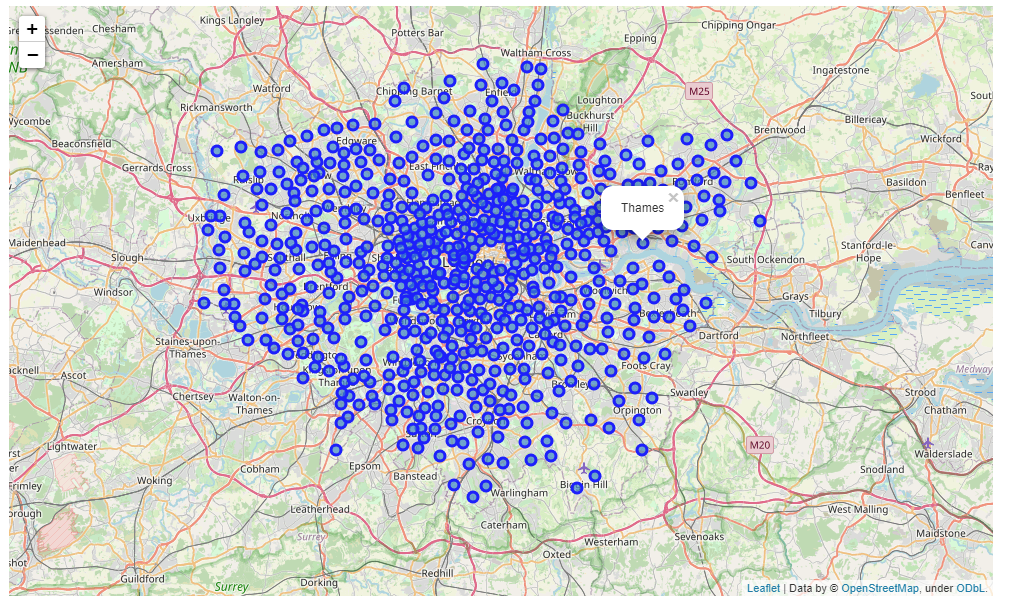

In [80]:
df.to_csv('LondonNeighbourhoods.csv') #Saving the neighbourhood data for nextweek

<h3 align=Left><font size = 4>Foursquare Data </font></h3>

#### Foursquare Credentials and Version

Credentials will be removed for github upload

In [107]:
CLIENT_ID = '####' # your Foursquare ID
CLIENT_SECRET = '####' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ####
CLIENT_SECRET:####


In [101]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [102]:
london_venues = getNearbyVenues(names=df['Neighbourhood'],
                                   latitudes=df['latitude'],
                                   longitudes=df['longitude']
                                  )

Abbey
Abbey
Abbey Road
Abbey Wood
Abingdon
Acton Central
Addiscombe East
Addiscombe West
Addison
Aldborough
Alexandra
Alexandra
Alibon
Alperton
Angel Town Centre
Askew
Avonmore and Brook Green
Balham
Barkingside
Barnehurst
Barnes
Barnhill
Barnhill
Barnsbury
Bayswater
Beckton
Becontree
Beddington North
Beddington South
Bedfont
Bedford
Bellingham
Belmont
Belmont
Belsize
Belvedere
Bensham Manor
Berrylands
Bethnal Green
Beverley
Bexleyheath
Bickley
Biggin Hill
Bishop's
Blackfen and Lamorbey
Blackheath
Blackheath Westcombe
Blackwall
Blendon and Penhill
Bloomsbury
Boleyn
Borough and Bankside
Botwell
Bounds Green
Bow East
Bow West
Bowes
Brentford
Bridge
Brixton Hill
Broad Green
Brockley
Bromley Common and Keston
Bromley North
Bromley South
Bromley Town
Brompton and Hans Town
Brondesbury Park
Brooklands
Brownswood
Bruce Grove
Brunel
Brunswick Park
Bryanston and Dorset Square
Bunhill
Burnt Oak
Bush Hill Park
Bushy Park
Caledonian
Camberwell Green
Camden Town with Primrose Hill
Campden
Canary Wh

Wembley Central
West Barnes
West Drayton
West End and Chinatown
West Finchley
West Green
West Ham
West Hampstead
West Harrow
West Heath
West Hendon
West Hill
West Putney
West Ruislip
West Thornton
West Twickenham
West Wickham
Westbourne
Westfield Shopping Centre
Whalebone
White Hart Lane
Whitechapel
Whitefoot
Whitton
Willesden Green
William Morris
Wimbledon Park
Winchmore Hill
Wood Street
Woodberry Down
Woodhouse
Woodside
Woodside
Woolwich Common
Woolwich Riverside
Worcester Park
Wormholt and White City
Yeading
Yiewsley


In [104]:
print(london_venues.shape)
london_venues.head()

(12076, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbey,51.5392,0.0801522,Nando's,51.539780,0.082297,Portuguese Restaurant
1,Abbey,51.5392,0.0801522,Cristina's,51.536523,0.076672,Steakhouse
2,Abbey,51.5392,0.0801522,The Gym London Barking,51.536193,0.078601,Gym
3,Abbey,51.5392,0.0801522,Subway,51.538000,0.081319,Sandwich Place
4,Abbey,51.5392,0.0801522,Costa Coffee,51.539272,0.081341,Coffee Shop


In [105]:
print('There are {} uniques categories.'.format(len(london_venues['Venue Category'].unique())))

There are 432 uniques categories.


Above is the foursquare data showing the most common venues in London neighbourhoods and it shows london has 432 unique venue categories (note the API was limited to 100 venue requests per location)

In [106]:
london_venues.to_csv('LondonVenues.csv') #Saving the venues data for nextweek